In [1]:
import torch
from dataloader import get_train_and_validation_dataloader
import matplotlib.pyplot as plt
import numpy as np
from data_importer import load_training_images, load_testing_images, trunc, denormalize

In [2]:
import numpy as np
import scipy.signal

from skimage.metrics import structural_similarity as ssim
def compute_MSE(img1, img2):
    return np.mean(np.square(img1 - img2))

def compute_PSNR(img1, img2, data_range):
    mse_ = compute_MSE(img1, img2)
    return 10 * np.log10((data_range ** 2) / mse_)

def calculate_ssim(original_image, reconstructed_image):    
    ssim_value = ssim(original_image.astype(np.float32), reconstructed_image.astype(np.float32), win_size=7,  channel_axis=2, data_range=240+160)
    return ssim_value




In [3]:
# Common testing image pairs (used to evaluate all models)
training_dataloader, validation_dataloader = get_train_and_validation_dataloader(root_dataset_dir='../../../../../Dataset/LowDoseCTGrandChallenge/Training_Image_Data', shuffle=False)

number of image paths :  15154
number of image paths :  1471
Train and validation data image len : 15154, 1471


Code for evaluation of model(s)

In [4]:
def visualize_patches(patches, noisy_images,  ground_truth_images, num_images):
    print(len(patches))
    num_patches_per_image = patches.shape[0] // num_images
    for i in range(num_images):
        print(patches[i].shape, ' shape of patches')
        image_patches = patches[i]
        noisy_patches = noisy_images[i]
        clean_patches = ground_truth_images[i]

        fig, axes = plt.subplots(1, 4, figsize=(30, 30))
        axes = axes.flatten()
        
        reconstruct_image = (trunc(denormalize((image_patches))))
        _noisy_image = trunc(denormalize((noisy_patches)))
        _clean_image = trunc(denormalize((clean_patches)))
        
        print('range of reconstructed image : ', np.min(reconstruct_image), np.max(reconstruct_image))
        print('range of clean image : ', np.min(_clean_image), np.max(_clean_image))

        print('reconstruct_image shape : ', reconstruct_image.shape)
        print('noisy image shape : ', noisy_images[i].shape)

        print('range of reconstructed values : ', np.min(reconstruct_image), np.max(reconstruct_image))

        
        axes[0].set_title('input image')
        axes[0].imshow(_noisy_image, cmap='gray', vmin=-160.0, vmax=240.0)
        axes[0].axis('off')
        
        axes[1].set_title('ground truth image')
        axes[1].imshow(_clean_image, cmap='gray', vmin=-160.0, vmax=240.0)
        axes[1].axis('off')
        
        axes[2].set_title('model prediction')
        axes[2].imshow((reconstruct_image), cmap='gray')
        axes[2].axis('off')
        
        axes[3].set_title('removed noise')
        axes[3].imshow(trunc(_noisy_image - reconstruct_image), cmap='gray', vmin=-160.0, vmax=240.0)
        axes[3].axis('off')
        
        print('PSNR of reconsturcted image : ', compute_PSNR(_clean_image, reconstruct_image, 240.0 + 160.0))
        print('PSNR of noisy image : ', compute_PSNR(_clean_image, _noisy_image, 240.0 + 160.0))
        print('SSIM of noisy image : ', calculate_ssim(_clean_image, _noisy_image))
        print('SSIM of reconstructed image : ', calculate_ssim(_clean_image, reconstruct_image))
        
        plt.show()


In [5]:
def evaluate_model(model, history, name, psnr_or_accuracy):
    print('Training history of model : ', name)
    
    print('Model prediction test')
   
    prediction_patches = []
    clean_patches = []
    noisy_patches = []

    with torch.no_grad():    
        for i, data in enumerate(validation_dataloader):
            noisy, clean = data
            print(noisy.shape)
        
            predictions = model(noisy.to('cuda'))

            prediction_patches.append(predictions.detach().cpu())
            clean_patches.append(clean.detach().cpu())
            noisy_patches.append(noisy.detach().cpu())
        
            if i == 3:
                break
        
    print('clean patches shape : ', clean_patches[0].shape)
    prediction_patches = np.concatenate(prediction_patches, axis=0)
    clean_patches = np.concatenate(clean_patches, axis=0)
    noisy_patches = np.concatenate(noisy_patches, axis=0)
    
    print('prediction patches shape : ', prediction_patches.shape)
    print('clean patches shape : ', clean_patches.shape)
    
    visualize_patches(prediction_patches, noisy_patches, clean_patches,len(prediction_patches))
    print('\n\n\n\n\n')
    
    print('\n\n\n\n\n')
    

Test on X model 

Layer (type:depth-idx)                        Param #
XModel                                        --
├─ConvTranspose2d: 1-1                        5
├─Conv2d: 1-2                                 16,448
├─InputProjectionLayer: 1-3                   --
│    └─Conv2d: 2-1                            640
├─OutputProjectionLayer: 1-4                  --
│    └─ConvTranspose2d: 2-2                   577
├─ConvBlock: 1-5                              --
│    └─ZeroPad2d: 2-3                         --
│    └─DepthWiseSeparableConv2d: 2-4          --
│    │    └─Conv2d: 3-1                       3,136
│    │    └─Conv2d: 3-2                       4,096
│    └─LayerNorm: 2-5                         --
│    └─Conv2d: 2-6                            803,072
│    └─GELU: 2-7                              --
│    └─Conv2d: 2-8                            16,448
├─ConvBlock: 1-6                              --
│    └─ZeroPad2d: 2-9                         --
│    └─DepthWiseSeparableConv2d: 2-10       

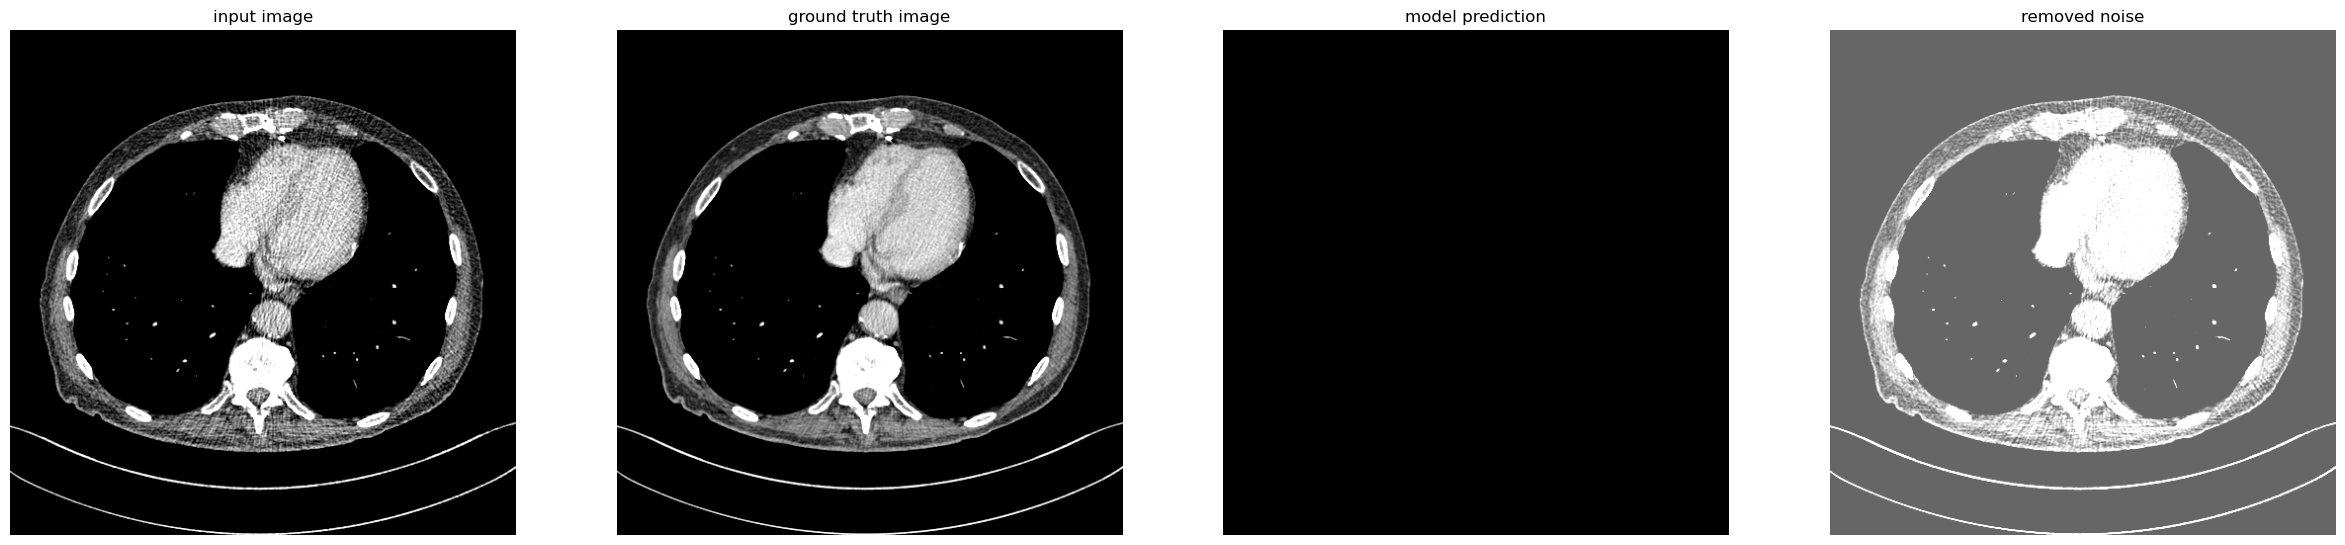

(512, 512, 1)  shape of patches
range of reconstructed image :  -160.0 -160.0
range of clean image :  -160.0 240.0
reconstruct_image shape :  (512, 512, 1)
noisy image shape :  (512, 512, 1)
range of reconstructed values :  -160.0 -160.0
PSNR of reconsturcted image :  10.324386275528335
PSNR of noisy image :  27.320032569500015
SSIM of noisy image :  0.9098041
SSIM of reconstructed image :  0.65538913


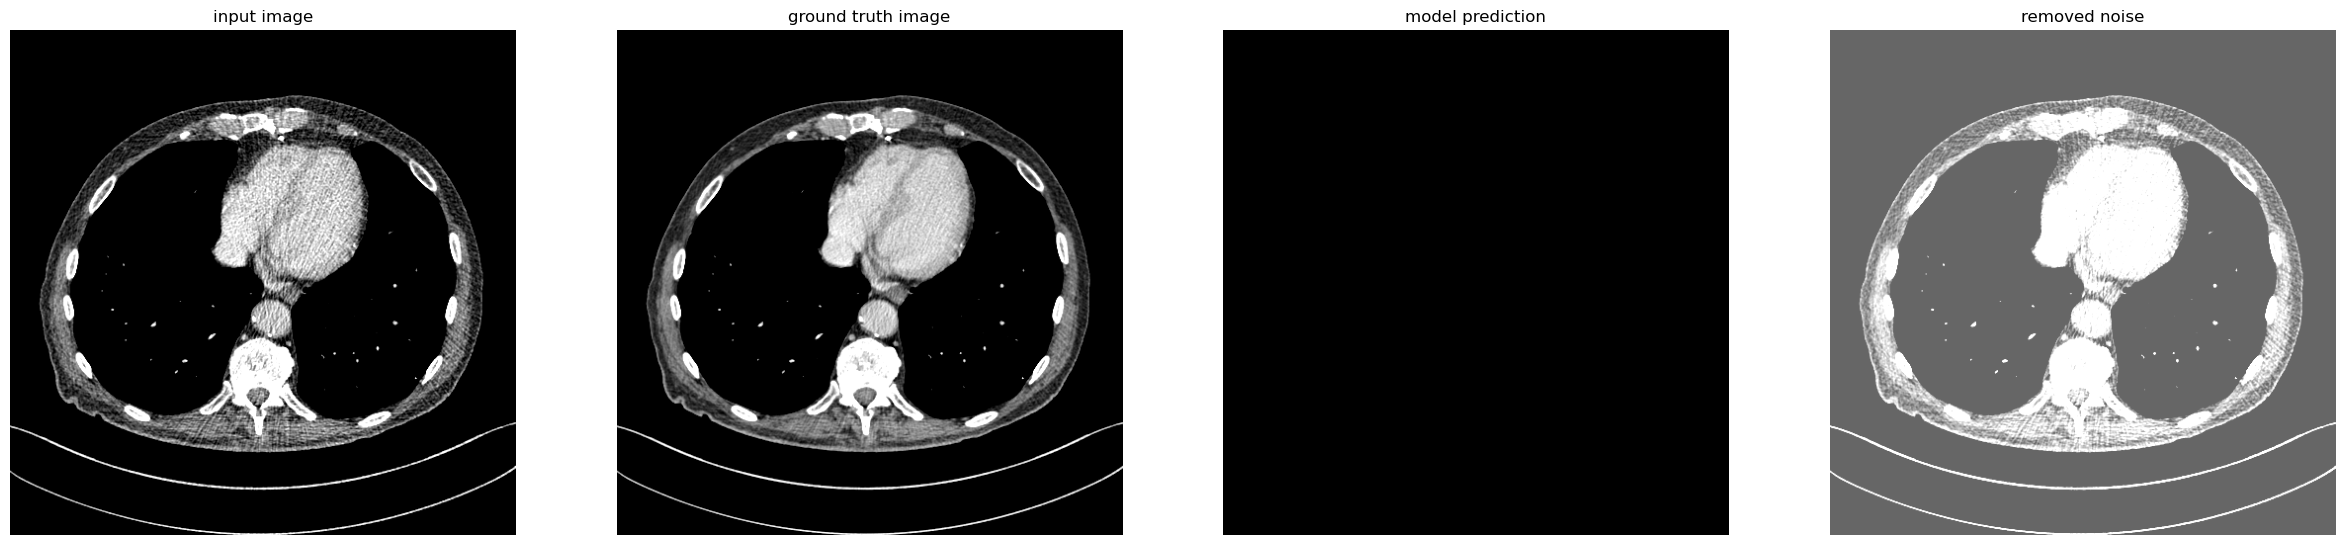

(512, 512, 1)  shape of patches
range of reconstructed image :  -160.0 -160.0
range of clean image :  -160.0 240.0
reconstruct_image shape :  (512, 512, 1)
noisy image shape :  (512, 512, 1)
range of reconstructed values :  -160.0 -160.0
PSNR of reconsturcted image :  10.359317475503325
PSNR of noisy image :  27.166770535120584
SSIM of noisy image :  0.90943474
SSIM of reconstructed image :  0.6582268


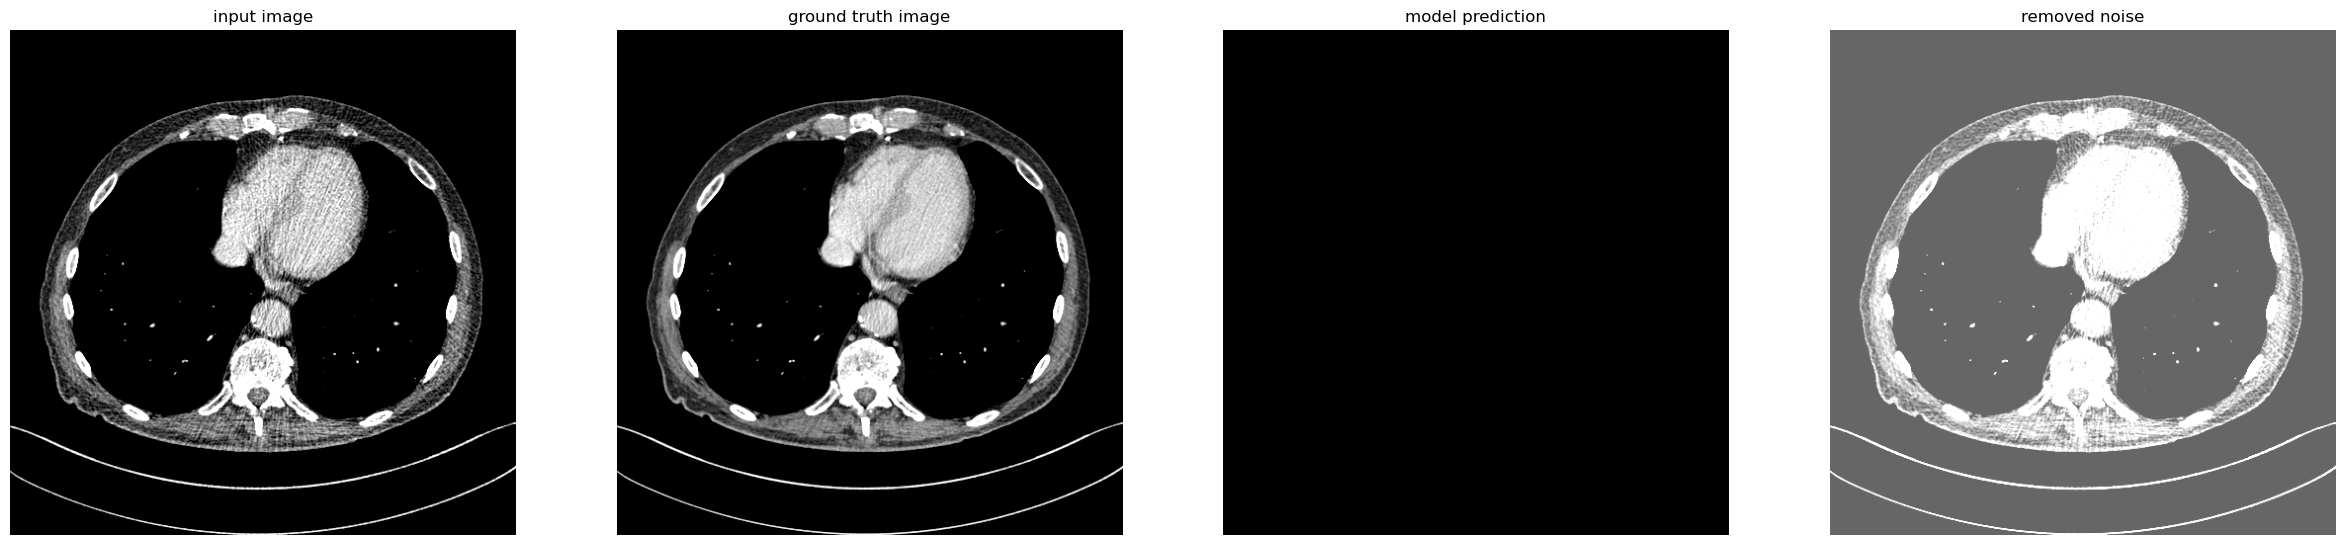

(512, 512, 1)  shape of patches
range of reconstructed image :  -160.0 -160.0
range of clean image :  -160.0 240.0
reconstruct_image shape :  (512, 512, 1)
noisy image shape :  (512, 512, 1)
range of reconstructed values :  -160.0 -160.0
PSNR of reconsturcted image :  10.389640253748345
PSNR of noisy image :  27.14835000044737
SSIM of noisy image :  0.90980643
SSIM of reconstructed image :  0.6589113


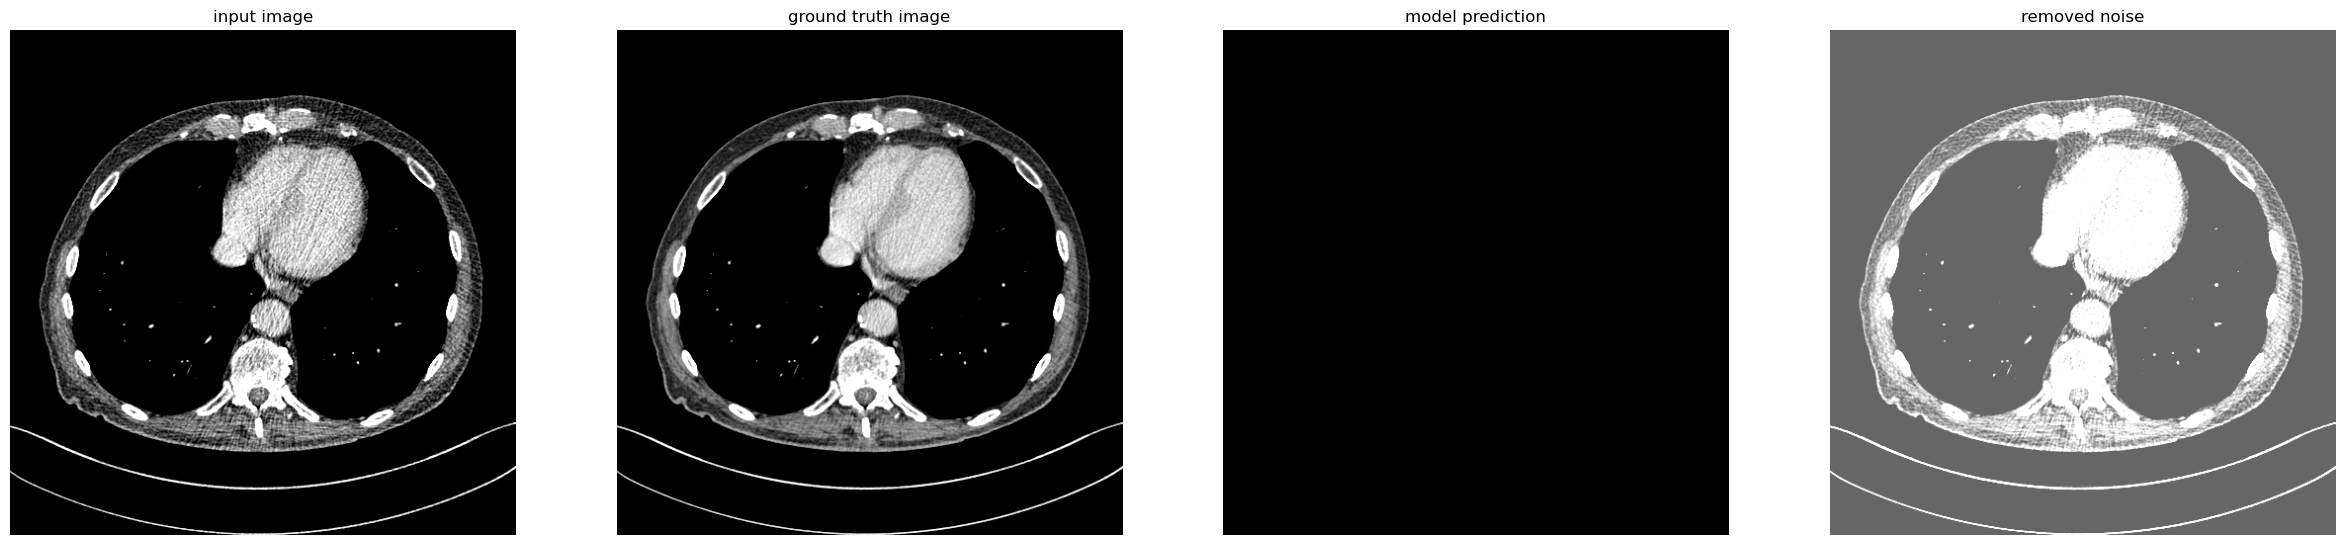

In [6]:
from x_denoiser import XModel 
from torchinfo import summary

model = XModel(num_channels=64).cuda()
model.load_state_dict(torch.load('weights/x_model/model_19.pth'))
model.eval()
print(summary(model))

evaluate_model(model, None, 'xmodel', 'psnr')

# Test for y model

Training history of model :  ymodel
Model prediction test
torch.Size([1, 512, 512, 1])
torch.Size([1, 512, 512, 1])
torch.Size([1, 512, 512, 1])
torch.Size([1, 512, 512, 1])
clean patches shape :  torch.Size([1, 512, 512, 1])
prediction patches shape :  (4, 512, 512, 1)
clean patches shape :  (4, 512, 512, 1)
4
(512, 512, 1)  shape of patches
range of reconstructed image :  -160.0 240.0
range of clean image :  -160.0 240.0
reconstruct_image shape :  (512, 512, 1)
noisy image shape :  (512, 512, 1)
range of reconstructed values :  -160.0 240.0
PSNR of reconsturcted image :  4.137622094851595
PSNR of noisy image :  26.821705141208817
SSIM of noisy image :  0.90582067
SSIM of reconstructed image :  0.00018874757


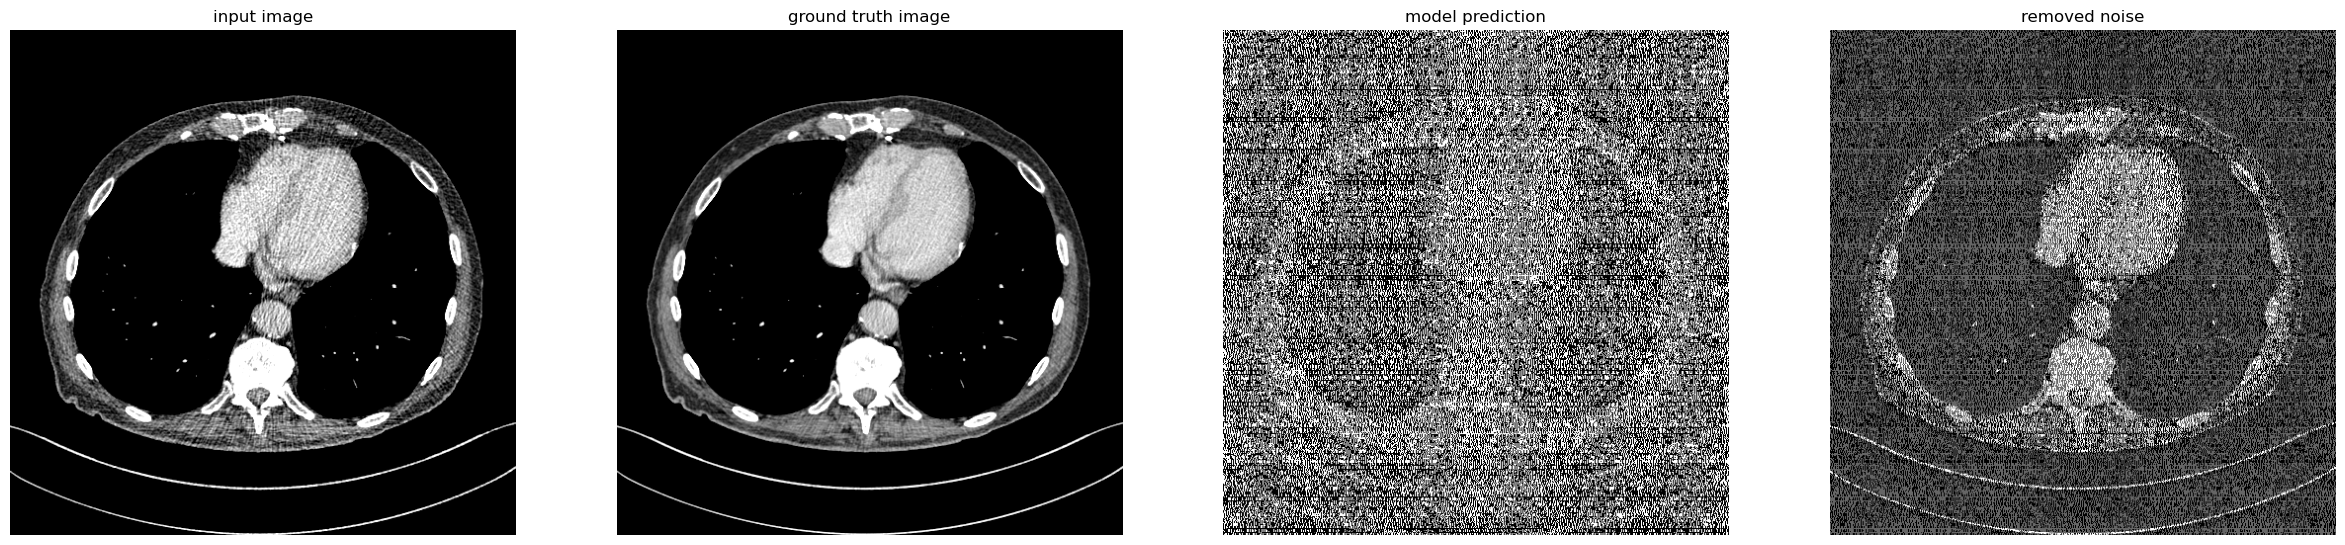

(512, 512, 1)  shape of patches
range of reconstructed image :  -160.0 240.0
range of clean image :  -160.0 240.0
reconstruct_image shape :  (512, 512, 1)
noisy image shape :  (512, 512, 1)
range of reconstructed values :  -160.0 240.0
PSNR of reconsturcted image :  4.138766685549262
PSNR of noisy image :  27.320032569500015
SSIM of noisy image :  0.9098041
SSIM of reconstructed image :  0.00034518234


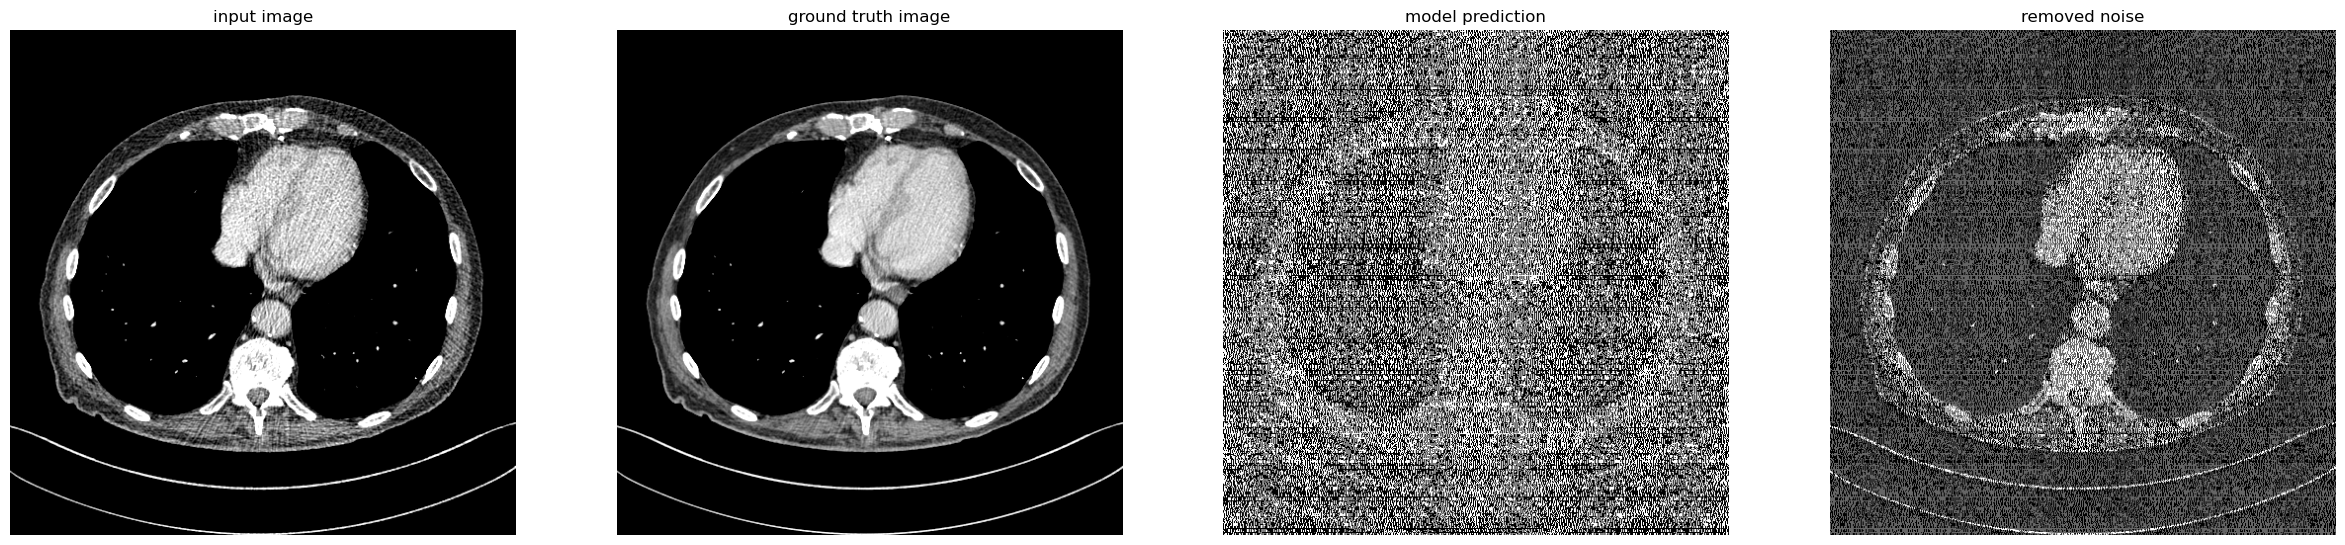

(512, 512, 1)  shape of patches
range of reconstructed image :  -160.0 240.0
range of clean image :  -160.0 240.0
reconstruct_image shape :  (512, 512, 1)
noisy image shape :  (512, 512, 1)
range of reconstructed values :  -160.0 240.0
PSNR of reconsturcted image :  4.141785639577479
PSNR of noisy image :  27.166770535120584
SSIM of noisy image :  0.90943474
SSIM of reconstructed image :  0.00028813028


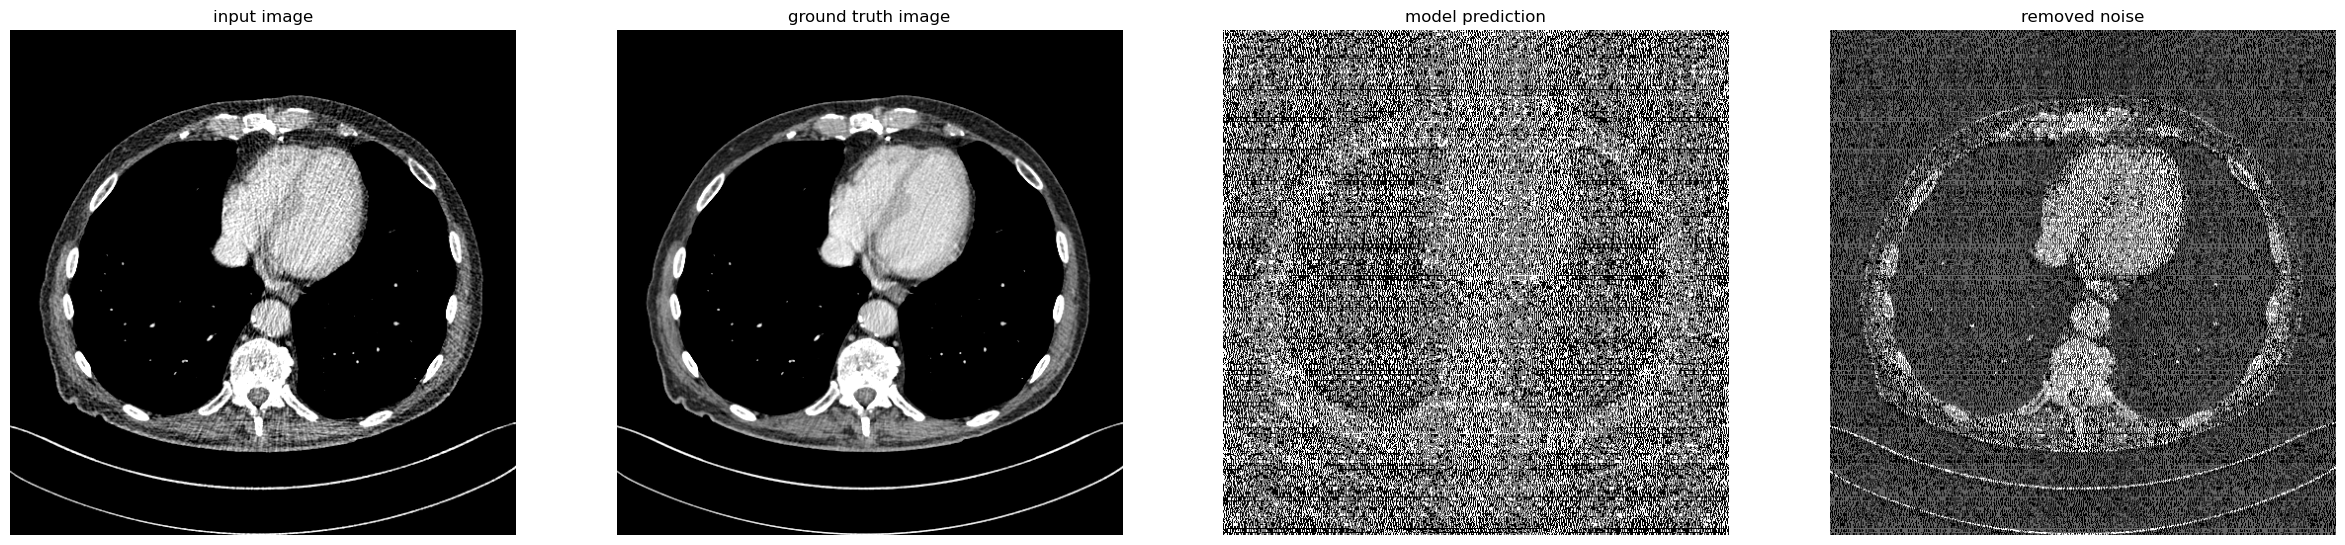

(512, 512, 1)  shape of patches
range of reconstructed image :  -160.0 240.0
range of clean image :  -160.0 240.0
reconstruct_image shape :  (512, 512, 1)
noisy image shape :  (512, 512, 1)
range of reconstructed values :  -160.0 240.0
PSNR of reconsturcted image :  4.135007137494959
PSNR of noisy image :  27.14835000044737
SSIM of noisy image :  0.90980643
SSIM of reconstructed image :  0.00018809277


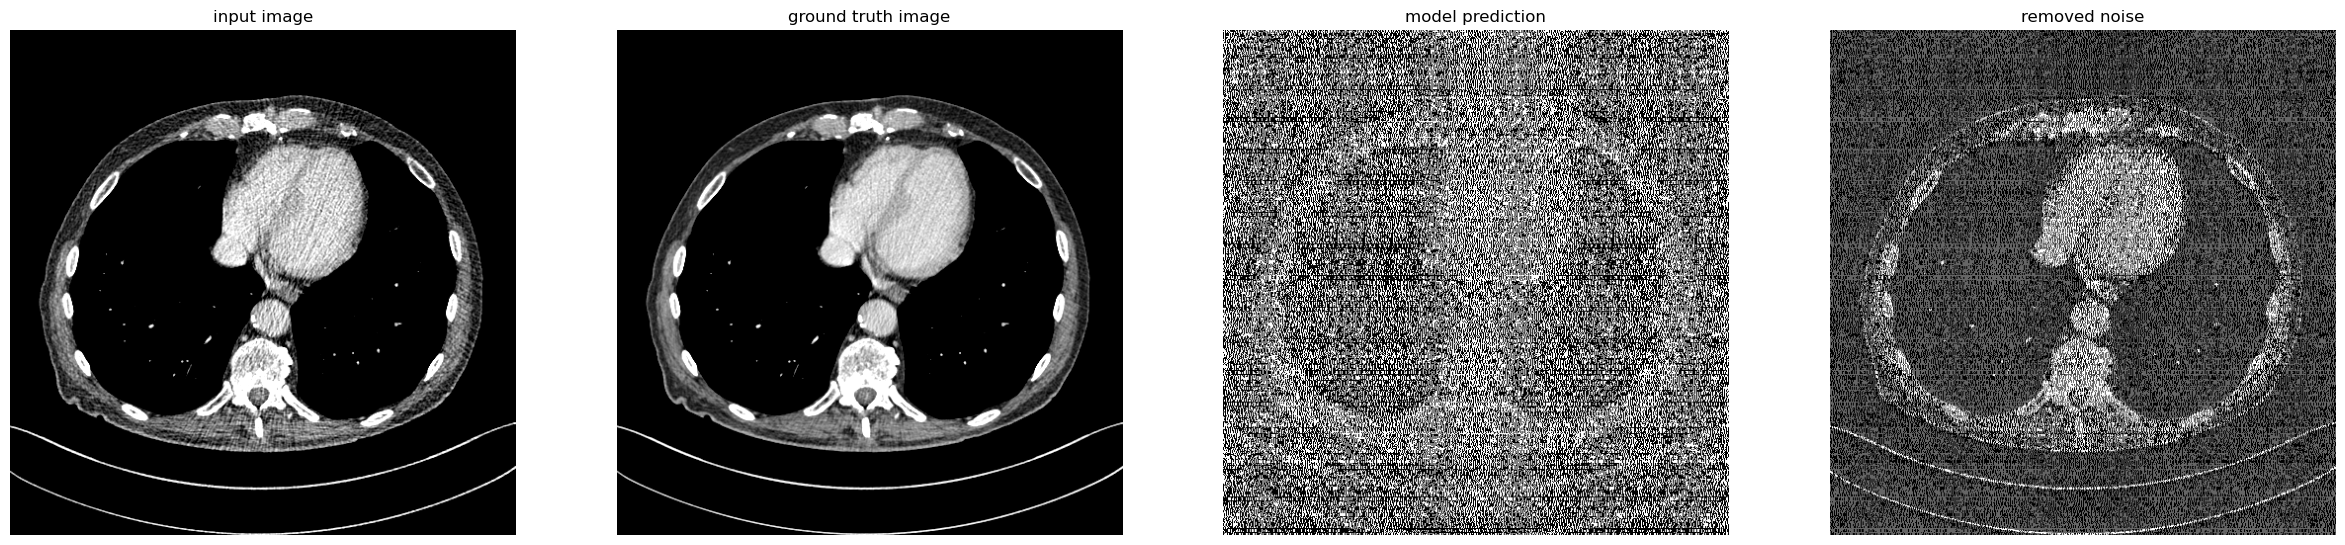

In [7]:

from y_denoiser import YModel 

model = YModel(num_channels=56).cuda()
model.load_state_dict(torch.load('weights/y_model/model_24.pth'))
model.eval()

evaluate_model(model, None, 'ymodel', 'psnr')